In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm

In [2]:
class KTHProcessedDataset(Dataset):
    def __init__(self, root_dir, sequence_length, transform=None):
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transform
        self.data = []
        self.class_mapping = {}  # To store class ID to name mapping

        # Traverse through action categories and their subfolders
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            category_path = os.path.join(root_dir, category)
            if not os.path.isdir(category_path):
                continue
            self.class_mapping[label] = category  # Map class ID to category name
            for subfolder in os.listdir(category_path):
                subfolder_path = os.path.join(category_path, subfolder)
                if os.path.isdir(subfolder_path):
                    frames = sorted(os.listdir(subfolder_path))  # Ensure frames are ordered

                    # Check if there are enough frames
                    if len(frames) >= sequence_length:
                        self.data.append((subfolder_path, frames, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subfolder_path, frames, label = self.data[idx]

        # Select frames sequentially from the start, up to sequence_length
        selected_frames = frames[:self.sequence_length]

        sequence = []
        for frame_file in selected_frames:
            frame_path = os.path.join(subfolder_path, frame_file)
            try:
                # Try to open the image
                img = Image.open(frame_path).convert("L")  # Convert to grayscale
                if self.transform:
                    img = self.transform(img)

                # Flatten the image to a 1D tensor
                img = img.view(-1)  # Flattening the image to size 4096 (64x64)
                sequence.append(img)

            except (IOError, OSError) as e:
                # Log the error and skip the corrupted frame
                print(f"Warning: Skipping corrupted image {frame_path} due to error: {e}")
                return self.__getitem__((idx + 1) % len(self))  # Skip to the next sample

        # Stack frames into a tensor of shape [sequence_length, 4096]
        sequence = torch.stack(sequence, dim=0)
        return sequence, label


In [3]:
# Define augmentations and transformations
transform = transforms.Compose([
    # Spatial augmentations
    # RandomHorizontalFlip(p=0.5),                # Flip frames horizontally with 50% probability
    # RandomRotation(degrees=15),                # Random rotation within ±15 degrees
    transforms.RandomCrop(size=(64, 64), pad_if_needed=True),  # Random crop to 64x64, pad if needed

    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.3),  # Adjust brightness/contrast
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),  # Random blur
    
    # Conversion and normalization
    transforms.ToTensor(),                                # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])           # Normalize to [-1, 1]
])

In [4]:
# Paths and hyperparameters
root_dir = '/home/nfs/inf6/data/datasets/kth_actions/processed'
sequence_length = 45
batch_size = 8
train_ratio = 0.8  # 80% for training, 20% for validation

In [5]:
# Load the full dataset
dataset = KTHProcessedDataset(root_dir=root_dir, sequence_length=sequence_length, transform=transform)

# Calculate train and validation sizes
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Dataset size: {dataset_size}")
print(f"Train set size: {train_size}")
print(f"Validation set size: {val_size}")

Dataset size: 599
Train set size: 479
Validation set size: 120


In [6]:
print("Dataset Classes:")
for class_id, class_name in dataset.class_mapping.items():
    print(f"Class ID: {class_id}, Class Name: {class_name}")

Dataset Classes:
Class ID: 0, Class Name: boxing
Class ID: 1, Class Name: handclapping
Class ID: 2, Class Name: handwaving
Class ID: 3, Class Name: jogging
Class ID: 4, Class Name: running
Class ID: 5, Class Name: walking


In [7]:
import wandb

In [8]:
def train_nn(model, train_loader, criterion, optimizer, device):
    """Train the LSTM model for one epoch"""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    for inputs, labels in train_loader:
        inputs = inputs.view(-1, 45, 1, height, width).to("cuda")
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Get outputs for the full sequence
        
        # Only use the last time step's output for classification
        loss = criterion(outputs, labels)  # Use the last timestep output
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy for the last time step
        _, predicted_labels = torch.max(outputs, dim=1)
        correct_labels += (predicted_labels == labels).sum().item()
        total_labels += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def evaluate_nn(model, eval_loader, criterion, device):
    """Evaluate the LSTM model"""
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs = inputs.view(-1, 45, 1, height, width).to("cuda")
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Get outputs for the full sequence
            
            loss = criterion(outputs, labels)  # Use the last timestep output
            running_loss += loss.item()

            # Compute accuracy for the last time step
            _, predicted_labels = torch.max(outputs, dim=1)
            correct_labels += (predicted_labels == labels).sum().item()
            total_labels += labels.size(0)

    avg_loss = running_loss / len(eval_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def run_training(model, train_loader, eval_loader, criterion, device, num_epochs, learning_rate=0.001, step_size=5, gamma=0.5, project_name='lstm_training'):
    """Train and evaluate the LSTM model for a given number of epochs with W&B logging"""
    # Initialize W&B logging
    wandb.init(project=project_name, config={
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "step_size": step_size,
        "gamma": gamma,
        "optimizer": "Adam",
    },
    )
    config = wandb.config

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)  # Learning rate scheduler
    
    train_losses = []
    eval_losses = []
    train_accuracies = []
    eval_accuracies = []
    learning_rates = []

    for epoch in tqdm(range(num_epochs)):
        # Train for one epoch
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device)
        # Evaluate after each epoch
        eval_loss, eval_accuracy = evaluate_nn(model, eval_loader, criterion, device)

        # Get current learning rate
        current_lr = scheduler.get_last_lr()[0]

        # Record the metrics
        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        train_accuracies.append(train_accuracy)
        eval_accuracies.append(eval_accuracy)
        learning_rates.append(current_lr)

        # Log metrics to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "eval_loss": eval_loss,
            "eval_accuracy": eval_accuracy,
            "learning_rate": current_lr
        })

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Step the learning rate scheduler
        scheduler.step()

    # Finish W&B run
    wandb.finish()

    return model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates

### ConvLSTM

In [9]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.bias = bias

        # Gates: i, f, o, g
        self.conv = nn.Conv2d(
            input_channels + hidden_channels, 
            4 * hidden_channels, 
            kernel_size, 
            padding=self.padding, 
            bias=self.bias
        )

    def forward(self, x, hidden):
        h_prev, c_prev = hidden

        # Concatenate along channel dimension
        combined = torch.cat([x, h_prev], dim=1)
        conv_output = self.conv(combined)

        # Split into gates
        i, f, o, g = torch.split(conv_output, self.hidden_channels, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        # Update cell state and hidden state
        c_next = f * c_prev + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, height, width):
        h = torch.zeros(batch_size, self.hidden_channels, height, width, device=self.conv.weight.device)
        c = torch.zeros(batch_size, self.hidden_channels, height, width, device=self.conv.weight.device)
        return h, c

In [10]:
class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers, num_classes, height, width, bias=True):
        super(ConvLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_channels = hidden_channels
        self.height = height
        self.width = width

        # ConvLSTM layers
        self.layers = nn.ModuleList([
            ConvLSTMCell(
                input_channels=input_channels if i == 0 else hidden_channels[i - 1],
                hidden_channels=hidden_channels[i],
                kernel_size=kernel_size,
                bias=bias
            ) for i in range(num_layers)
        ])

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_channels[-1] * height * width, num_classes)

    def forward(self, x):
        """
        x: [batch_size, sequence_length, channels, height, width]
        Returns logits for classification.
        """
        # print(x.shape)
        batch_size, seq_len, _, height, width = x.size()
        assert height == self.height and width == self.width, "Input size mismatch with initialized height and width."

        # Initialize hidden states for all layers
        hidden_states = [layer.init_hidden(batch_size, height, width) for layer in self.layers]

        # Process sequence through ConvLSTM layers
        for t in range(seq_len):
            current_input = x[:, t]
            for l, layer in enumerate(self.layers):
                hidden_states[l] = layer(current_input, hidden_states[l])
                current_input = hidden_states[l][0]  # Use the hidden state (h_t)

        # Last layer's hidden state at the last time step
        last_hidden_state = hidden_states[-1][0]  # Shape: [batch_size, hidden_channels[-1], height, width]

        # Flatten and classify
        last_hidden_state_flat = last_hidden_state.view(batch_size, -1)  # Flatten: [batch_size, hidden_channels[-1] * height * width]
        logits = self.fc(last_hidden_state_flat)  # [batch_size, num_classes]
        return logits

In [11]:
# Initialize ConvLSTM
input_channels = 1  # Grayscale images
hidden_channels = [64, 128]  # Two layers with 64 and 128 hidden channels
kernel_size = 3
num_layers = len(hidden_channels)
num_classes=6
height=64
width=64

model = ConvLSTM(
    input_channels=input_channels,
    hidden_channels=hidden_channels,
    kernel_size=kernel_size,
    num_layers=num_layers,
    num_classes=num_classes,
    height=height,
    width=width
).to("cuda")

In [12]:
model

ConvLSTM(
  (layers): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(192, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (fc): Linear(in_features=524288, out_features=6, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Hyperparameters
num_epochs = 40
learning_rate = 0.001
step_size = 5
gamma = 0.5

# Run training
model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates = run_training(
    model, train_loader, val_loader, criterion, device,
    num_epochs, learning_rate, step_size, gamma, 'convlstm_training'
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmadjaved97. Use `wandb login --relogin` to force relogin


  2%|█▍                                                      | 1/40 [00:43<28:29, 43.83s/it]

Epoch 1/40
Train Loss: 1.9241, Train Accuracy: 0.2109
Eval Loss: 1.5918, Eval Accuracy: 0.2917
Learning Rate: 0.001000


  5%|██▊                                                     | 2/40 [01:27<27:46, 43.86s/it]

Epoch 2/40
Train Loss: 1.6205, Train Accuracy: 0.3361
Eval Loss: 1.5339, Eval Accuracy: 0.3500
Learning Rate: 0.001000


  8%|████▏                                                   | 3/40 [02:11<27:06, 43.96s/it]

Epoch 3/40
Train Loss: 1.4784, Train Accuracy: 0.4029
Eval Loss: 1.4861, Eval Accuracy: 0.4083
Learning Rate: 0.001000


 10%|█████▌                                                  | 4/40 [02:55<26:25, 44.04s/it]

Epoch 4/40
Train Loss: 1.2831, Train Accuracy: 0.4802
Eval Loss: 1.8770, Eval Accuracy: 0.4083
Learning Rate: 0.001000


 12%|███████                                                 | 5/40 [03:40<25:43, 44.10s/it]

Epoch 5/40
Train Loss: 0.9751, Train Accuracy: 0.6096
Eval Loss: 1.2064, Eval Accuracy: 0.5167
Learning Rate: 0.001000


 15%|████████▍                                               | 6/40 [04:24<25:01, 44.15s/it]

Epoch 6/40
Train Loss: 0.5523, Train Accuracy: 0.7912
Eval Loss: 1.2938, Eval Accuracy: 0.5250
Learning Rate: 0.000500


 18%|█████████▊                                              | 7/40 [05:08<24:17, 44.17s/it]

Epoch 7/40
Train Loss: 0.3584, Train Accuracy: 0.8789
Eval Loss: 1.4441, Eval Accuracy: 0.5167
Learning Rate: 0.000500


 20%|███████████▏                                            | 8/40 [05:52<23:34, 44.19s/it]

Epoch 8/40
Train Loss: 0.1671, Train Accuracy: 0.9541
Eval Loss: 1.8865, Eval Accuracy: 0.5333
Learning Rate: 0.000500


 22%|████████████▌                                           | 9/40 [06:37<22:50, 44.20s/it]

Epoch 9/40
Train Loss: 0.1154, Train Accuracy: 0.9624
Eval Loss: 1.7071, Eval Accuracy: 0.5000
Learning Rate: 0.000500


 25%|█████████████▊                                         | 10/40 [07:21<22:06, 44.21s/it]

Epoch 10/40
Train Loss: 0.0572, Train Accuracy: 0.9833
Eval Loss: 2.0636, Eval Accuracy: 0.5333
Learning Rate: 0.000500


 28%|███████████████▏                                       | 11/40 [08:05<21:22, 44.24s/it]

Epoch 11/40
Train Loss: 0.0216, Train Accuracy: 0.9958
Eval Loss: 2.2162, Eval Accuracy: 0.5167
Learning Rate: 0.000250


 30%|████████████████▌                                      | 12/40 [08:49<20:38, 44.23s/it]

Epoch 12/40
Train Loss: 0.0159, Train Accuracy: 0.9979
Eval Loss: 2.3125, Eval Accuracy: 0.5667
Learning Rate: 0.000250


 32%|█████████████████▉                                     | 13/40 [09:34<19:54, 44.25s/it]

Epoch 13/40
Train Loss: 0.0197, Train Accuracy: 0.9979
Eval Loss: 2.4941, Eval Accuracy: 0.5083
Learning Rate: 0.000250


 35%|███████████████████▎                                   | 14/40 [10:18<19:10, 44.26s/it]

Epoch 14/40
Train Loss: 0.0040, Train Accuracy: 1.0000
Eval Loss: 2.5099, Eval Accuracy: 0.5083
Learning Rate: 0.000250


 38%|████████████████████▋                                  | 15/40 [11:02<18:26, 44.27s/it]

Epoch 15/40
Train Loss: 0.0022, Train Accuracy: 1.0000
Eval Loss: 2.7113, Eval Accuracy: 0.5083
Learning Rate: 0.000250


 40%|██████████████████████                                 | 16/40 [11:46<17:42, 44.26s/it]

Epoch 16/40
Train Loss: 0.0018, Train Accuracy: 1.0000
Eval Loss: 2.7297, Eval Accuracy: 0.5083
Learning Rate: 0.000125


 42%|███████████████████████▍                               | 17/40 [12:31<16:58, 44.26s/it]

Epoch 17/40
Train Loss: 0.0017, Train Accuracy: 1.0000
Eval Loss: 2.9159, Eval Accuracy: 0.5250
Learning Rate: 0.000125


 45%|████████████████████████▊                              | 18/40 [13:15<16:13, 44.26s/it]

Epoch 18/40
Train Loss: 0.0013, Train Accuracy: 1.0000
Eval Loss: 2.9464, Eval Accuracy: 0.4917
Learning Rate: 0.000125


 48%|██████████████████████████▏                            | 19/40 [13:59<15:29, 44.25s/it]

Epoch 19/40
Train Loss: 0.0011, Train Accuracy: 1.0000
Eval Loss: 2.9424, Eval Accuracy: 0.5167
Learning Rate: 0.000125


 50%|███████████████████████████▌                           | 20/40 [14:43<14:45, 44.25s/it]

Epoch 20/40
Train Loss: 0.0011, Train Accuracy: 1.0000
Eval Loss: 3.0729, Eval Accuracy: 0.5167
Learning Rate: 0.000125


 52%|████████████████████████████▉                          | 21/40 [15:28<14:00, 44.26s/it]

Epoch 21/40
Train Loss: 0.0009, Train Accuracy: 1.0000
Eval Loss: 3.0518, Eval Accuracy: 0.5083
Learning Rate: 0.000063


 55%|██████████████████████████████▎                        | 22/40 [16:12<13:16, 44.26s/it]

Epoch 22/40
Train Loss: 0.0010, Train Accuracy: 1.0000
Eval Loss: 3.0578, Eval Accuracy: 0.5000
Learning Rate: 0.000063


 57%|███████████████████████████████▌                       | 23/40 [16:56<12:32, 44.26s/it]

Epoch 23/40
Train Loss: 0.0009, Train Accuracy: 1.0000
Eval Loss: 2.9121, Eval Accuracy: 0.5083
Learning Rate: 0.000063


 60%|█████████████████████████████████                      | 24/40 [17:40<11:48, 44.26s/it]

Epoch 24/40
Train Loss: 0.0008, Train Accuracy: 1.0000
Eval Loss: 3.0837, Eval Accuracy: 0.5000
Learning Rate: 0.000063


 62%|██████████████████████████████████▍                    | 25/40 [18:25<11:03, 44.25s/it]

Epoch 25/40
Train Loss: 0.0008, Train Accuracy: 1.0000
Eval Loss: 3.0778, Eval Accuracy: 0.5167
Learning Rate: 0.000063


 65%|███████████████████████████████████▊                   | 26/40 [19:09<10:19, 44.23s/it]

Epoch 26/40
Train Loss: 0.0008, Train Accuracy: 1.0000
Eval Loss: 3.1352, Eval Accuracy: 0.5167
Learning Rate: 0.000031


 68%|█████████████████████████████████████▏                 | 27/40 [19:53<09:35, 44.25s/it]

Epoch 27/40
Train Loss: 0.0007, Train Accuracy: 1.0000
Eval Loss: 3.1834, Eval Accuracy: 0.5083
Learning Rate: 0.000031


 70%|██████████████████████████████████████▌                | 28/40 [20:37<08:50, 44.24s/it]

Epoch 28/40
Train Loss: 0.0007, Train Accuracy: 1.0000
Eval Loss: 3.1539, Eval Accuracy: 0.5083
Learning Rate: 0.000031


 72%|███████████████████████████████████████▉               | 29/40 [21:22<08:06, 44.26s/it]

Epoch 29/40
Train Loss: 0.0007, Train Accuracy: 1.0000
Eval Loss: 3.1439, Eval Accuracy: 0.5083
Learning Rate: 0.000031


 75%|█████████████████████████████████████████▎             | 30/40 [22:06<07:22, 44.26s/it]

Epoch 30/40
Train Loss: 0.0007, Train Accuracy: 1.0000
Eval Loss: 3.1934, Eval Accuracy: 0.5000
Learning Rate: 0.000031


 78%|██████████████████████████████████████████▋            | 31/40 [22:50<06:38, 44.24s/it]

Epoch 31/40
Train Loss: 0.0006, Train Accuracy: 1.0000
Eval Loss: 3.2377, Eval Accuracy: 0.5083
Learning Rate: 0.000016


 80%|████████████████████████████████████████████           | 32/40 [23:34<05:53, 44.23s/it]

Epoch 32/40
Train Loss: 0.0006, Train Accuracy: 1.0000
Eval Loss: 3.1393, Eval Accuracy: 0.5333
Learning Rate: 0.000016


 82%|█████████████████████████████████████████████▍         | 33/40 [24:19<05:09, 44.25s/it]

Epoch 33/40
Train Loss: 0.0006, Train Accuracy: 1.0000
Eval Loss: 3.0903, Eval Accuracy: 0.5167
Learning Rate: 0.000016


 85%|██████████████████████████████████████████████▊        | 34/40 [25:03<04:25, 44.26s/it]

Epoch 34/40
Train Loss: 0.0006, Train Accuracy: 1.0000
Eval Loss: 3.1103, Eval Accuracy: 0.5250
Learning Rate: 0.000016


 88%|████████████████████████████████████████████████▏      | 35/40 [25:47<03:41, 44.25s/it]

Epoch 35/40
Train Loss: 0.0005, Train Accuracy: 1.0000
Eval Loss: 3.1236, Eval Accuracy: 0.5167
Learning Rate: 0.000016


 90%|█████████████████████████████████████████████████▌     | 36/40 [26:31<02:56, 44.25s/it]

Epoch 36/40
Train Loss: 0.0006, Train Accuracy: 1.0000
Eval Loss: 3.2621, Eval Accuracy: 0.5167
Learning Rate: 0.000008


 92%|██████████████████████████████████████████████████▉    | 37/40 [27:16<02:12, 44.27s/it]

Epoch 37/40
Train Loss: 0.0006, Train Accuracy: 1.0000
Eval Loss: 3.1321, Eval Accuracy: 0.5167
Learning Rate: 0.000008


 95%|████████████████████████████████████████████████████▎  | 38/40 [28:00<01:28, 44.27s/it]

Epoch 38/40
Train Loss: 0.0006, Train Accuracy: 1.0000
Eval Loss: 3.2780, Eval Accuracy: 0.5083
Learning Rate: 0.000008


 98%|█████████████████████████████████████████████████████▋ | 39/40 [28:44<00:44, 44.26s/it]

Epoch 39/40
Train Loss: 0.0006, Train Accuracy: 1.0000
Eval Loss: 3.1349, Eval Accuracy: 0.5167
Learning Rate: 0.000008


100%|███████████████████████████████████████████████████████| 40/40 [29:28<00:00, 44.22s/it]

Epoch 40/40
Train Loss: 0.0006, Train Accuracy: 1.0000
Eval Loss: 3.2023, Eval Accuracy: 0.5167
Learning Rate: 0.000008


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval_accuracy,▁▂▄▄▇▇▇▇▆▇▇█▇▇▇▇▇▆▇▇▇▆▇▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇
eval_loss,▂▂▂▃▁▁▂▃▃▄▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇███████▇▇▇█████
learning_rate,█████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▃▃▅▆▇█████████████████████████████████
train_loss,█▇▆▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
eval_accuracy,0.51667
eval_loss,3.20229
learning_rate,1e-05
train_accuracy,1


In [25]:
!pip install scikit-learn

     |████████████████████████████████| 11.1 MB 9.4 MB/s eta 0:00:01
     |████████████████████████████████| 34.5 MB 11 kB/s /s eta 0:00:01     |███████████████▋                | 16.9 MB 102.0 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 131.2 MB/s eta 0:00:01


In [29]:
!pip install seaborn

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [31]:
def plot_confusion_matrix(y_true, y_pred, label_names, model_name):
    """
    Plots confusion matrix for a given model.

    Args:
        y_true (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted labels.
        label_names (list): List of class names.
        model_name (str): The name of the model to display in the plot title.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names, linewidths=1)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


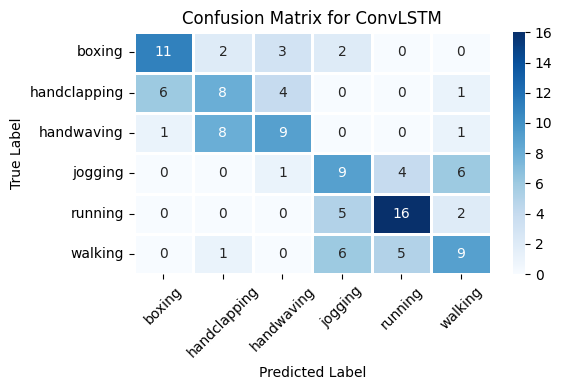

In [32]:
# Function to evaluate model and compute predictions
def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in dataloader:
            # Reshape and move to device
            sequences = sequences.view(-1, 45, 1, 64, 64).to(device)
            labels = labels.to(device)

            # Get predictions
            outputs = model(sequences)
            preds = torch.argmax(outputs, dim=1)

            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Use the function to get results
y_true, y_pred = evaluate_model(model, val_loader)

# Class label names
# label_names = [name for _, name in sorted(KTHProcessedDataset.class_mapping.items())]
label_names = ['boxing','handclapping', 'handwaving', 'jogging', 'running', 'walking']

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred,label_names, model_name="ConvLSTM")